## tiny mnist classifier ##

model is simple 2 layer convnet with < 100k params. nothing special or amazing.

default mnist: 99.22% test accuracy

[fashion](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md) drop-in replcement for mnist: 92.47%

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import namedtuple

from matplotlib import pyplot as plt
from PIL import Image

import os
import os.path
import errno
import codecs
import copy

In [2]:
np.random.seed(1)
torch.manual_seed(1)

In [3]:
class MNIST(torch.utils.data.Dataset):
  """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
  Args:
    root (string): Root directory of dataset where ``processed/training.pt``
      and  ``processed/test.pt`` exist.
    dataset (string): If `train`, create dataset from ``training.pt``,
      otherwise from ``test.pt``.
    download (bool, optional): If true, downloads the dataset from the internet and
      puts it in root directory. If dataset is already downloaded, it is not
      downloaded again.
    transform (callable, optional): A function/transform that  takes in an PIL image
      and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/transform that takes in the
      target and transforms it.
  """
  mnist_base_url = 'http://yann.lecun.com/exdb/mnist/'
  fasion_base_url = 'https://cdn.rawgit.com/zalandoresearch/fashion-mnist/ed8e4f3b/data/fashion/'
  #base_url = mnist_base_url # change one line to change datasets
  base_url = fasion_base_url
  urls = [
    base_url+'train-images-idx3-ubyte.gz',
    base_url+'train-labels-idx1-ubyte.gz',
    base_url+'t10k-images-idx3-ubyte.gz',
    base_url+'t10k-labels-idx1-ubyte.gz',
  ]
  raw_folder = 'raw'
  processed_folder = 'processed'
  training_file = 'training.pt'
  test_file = 'test.pt'

  def __init__(self, root, dataset='train', transform=None, target_transform=None, download=False, force_download=False):
    self.root = os.path.expanduser(root)
    self.transform = transform
    self.target_transform = target_transform
    self.dataset = dataset  # 'train' or 'test'
    
    self.force_download = force_download # if True, will download dataset everytime no matter what.

    if download:
      self.download()

    if not self._check_exists():
      raise RuntimeError('Dataset not found.' +
                        ' You can use download=True to download it')

    if self.dataset == 'train':
      self.data, self.labels = torch.load(os.path.join(root, self.processed_folder, self.training_file))
    else:
      self.data, self.labels = torch.load(os.path.join(root, self.processed_folder, self.test_file))

  def __getitem__(self, index):
      """
      Args:
        index (int): Index
      Returns:
        tuple: (image, target) where target is index of the target class.
      """
      img, target = self.data[index], self.labels[index]

      # doing this so that it is consistent with all other datasets
      # to return a PIL Image
      img = Image.fromarray(img.numpy(), mode='L')

      if self.transform is not None:
        img = self.transform(img)

      if self.target_transform is not None:
        target = self.target_transform(target)

      return img, target

  def __len__(self):
    return len(self.data)

  def _check_exists(self):
    return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
      os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

  def download(self):
    """Download the MNIST data if it doesn't exist in processed_folder already."""
    from six.moves import urllib
    import gzip

    if self._check_exists() and (not self.force_download):
      return

    # download files
    try:
      os.makedirs(os.path.join(self.root, self.raw_folder))
      os.makedirs(os.path.join(self.root, self.processed_folder))
    except OSError as e:
      if e.errno == errno.EEXIST:
        pass
      else:
        raise

    for url in self.urls:
      print('Downloading ' + url)
      data = urllib.request.urlopen(url)
      filename = url.rpartition('/')[2]
      file_path = os.path.join(self.root, self.raw_folder, filename)
      with open(file_path, 'wb') as f:
          f.write(data.read())
      with open(file_path.replace('.gz', ''), 'wb') as out_f, \
              gzip.GzipFile(file_path) as zip_f:
          out_f.write(zip_f.read())
      os.unlink(file_path)

    # process and save as torch files
    print('Processing...')

    training_set = (
      read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte')),
      read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'))
    )
    test_set = (
      read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte')),
      read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'))
    )
    with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
      torch.save(training_set, f)
    with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
      torch.save(test_set, f)

    print('Done!')


def get_int(b):
  return int(codecs.encode(b, 'hex'), 16)


def parse_byte(b):
  if isinstance(b, str):
    return ord(b)
  return b


def read_label_file(path):
  with open(path, 'rb') as f:
    data = f.read()
    assert get_int(data[:4]) == 2049
    length = get_int(data[4:8])
    labels = [parse_byte(b) for b in data[8:]]
    assert len(labels) == length
    return torch.LongTensor(labels)


def read_image_file(path):
  with open(path, 'rb') as f:
    data = f.read()
    assert get_int(data[:4]) == 2051
    length = get_int(data[4:8])
    num_rows = get_int(data[8:12])
    num_cols = get_int(data[12:16])
    images = []
    idx = 16
    for l in range(length):
      img = []
      images.append(img)
      for r in range(num_rows):
        row = []
        img.append(row)
        for c in range(num_cols):
          row.append(parse_byte(data[idx]))
          idx += 1
    assert len(images) == length
    return torch.ByteTensor(images).view(-1, 28, 28)


In [4]:
Args = namedtuple('Args', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'cuda', 'seed', 'log_interval'])

In [5]:
args = Args(batch_size=1000, test_batch_size=1000, epochs=30, lr=0.001, cuda=True, seed=0, log_interval=10)

In [6]:
torch.manual_seed(args.seed)
if args.cuda:
  torch.cuda.manual_seed(args.seed)

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

In [8]:
train_loader = torch.utils.data.DataLoader(
  MNIST('MNIST_data', dataset='train', download=True, force_download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

Processing...
Done!


In [9]:
test_loader = torch.utils.data.DataLoader(
  MNIST('MNIST_data', dataset='test', download=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

In [10]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    # input is 28x28
    # padding=2 for same padding
    self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
    # feature map size is 14*14 by pooling
    # padding=2 for same padding
    self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
    # feature map size is 7*7 by pooling
    self.fc = nn.Linear(64*7*7, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, 64*7*7)   # reshape Variable
    x = self.fc(x)
    return F.log_softmax(x)

In [11]:
model = Net()
if args.cuda:
  model.cuda()

orig_model = copy.deepcopy(model)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [12]:
def train(epoch, model, train_loader):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % args.log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))

In [13]:
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * acc))
  return acc

In [14]:
for epoch in range(1, args.epochs + 1):
  train(epoch, model, train_loader)

eval_acc = evaluate(model, test_loader)
print('final test acc', eval_acc * 100.)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301235
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.846406
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.630566
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.626907
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.512379
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.534668
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.455365
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.436770
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.367981
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.382901
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.386512
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.383592
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.395101
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.349057
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.358162
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.370354
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.323364
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.344763
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.300676
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.326958
Train Epoch: 4 [2000

Train Epoch: 28 [30000/60000 (50%)]	Loss: 0.130084
Train Epoch: 28 [40000/60000 (67%)]	Loss: 0.117223
Train Epoch: 28 [50000/60000 (83%)]	Loss: 0.112890
Train Epoch: 29 [0/60000 (0%)]	Loss: 0.106545
Train Epoch: 29 [10000/60000 (17%)]	Loss: 0.138326
Train Epoch: 29 [20000/60000 (33%)]	Loss: 0.140573
Train Epoch: 29 [30000/60000 (50%)]	Loss: 0.110409
Train Epoch: 29 [40000/60000 (67%)]	Loss: 0.126531
Train Epoch: 29 [50000/60000 (83%)]	Loss: 0.110660
Train Epoch: 30 [0/60000 (0%)]	Loss: 0.083104
Train Epoch: 30 [10000/60000 (17%)]	Loss: 0.133573
Train Epoch: 30 [20000/60000 (33%)]	Loss: 0.122839
Train Epoch: 30 [30000/60000 (50%)]	Loss: 0.116113
Train Epoch: 30 [40000/60000 (67%)]	Loss: 0.107554
Train Epoch: 30 [50000/60000 (83%)]	Loss: 0.102511

Average loss: 0.2338, Accuracy: 9247/10000 (92.4700%)

final test acc 92.47


In [15]:
param_count = 0
for param in model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([10, 3136])
torch.Size([10])
83466


In [16]:
final_params = []
for param in model.parameters():
  final_params.append(param.data.cpu().numpy().flatten())
final_params_flat = np.concatenate(final_params)

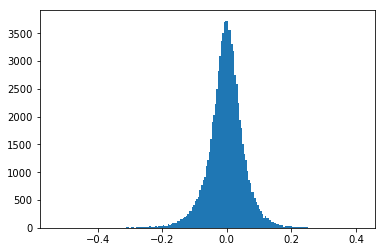

In [17]:
_ = plt.hist(final_params_flat, bins=200)
plt.show()

In [18]:
def get_random_data(data_loader, num=10):
  random_data = []
  for batch_idx, (data, target) in enumerate(data_loader):
    random_data.append((data[np.random.randint(0, 1000)]).numpy().reshape(28, 28))
    if len(random_data) > num:
      break
  return random_data

def display_data(random_data):
  for img in random_data:
    _ = plt.subplots(figsize=(1, 1))
    plt.imshow(1.0-img, cmap='gray')
    plt.show()

In [19]:
random_train_data = get_random_data(train_loader)
random_test_data = get_random_data(test_loader)

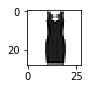

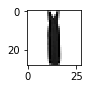

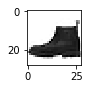

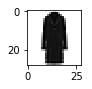

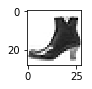

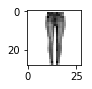

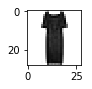

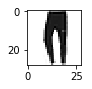

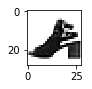

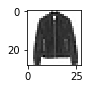

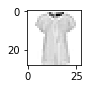

In [20]:
display_data(random_train_data)

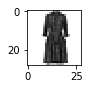

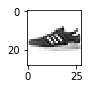

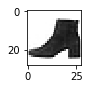

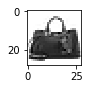

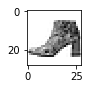

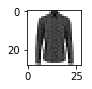

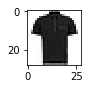

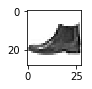

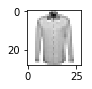

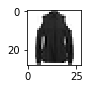

In [21]:
display_data(random_test_data)